In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from numba import jit
import time

In [67]:
F = 8.0
K = 40
k = np.empty(K)
k1 = np.empty(K)
k2 = np.empty(K)
k3 = np.empty(K)
k4 = np.empty(K)
Xtmp1 = np.empty(K)
Xtmp2 = np.empty(K)
Xtmp3 = np.empty(K)

In [68]:
@jit
def df(X):
    nextX = np.empty(K)
    for j in range(K):
        if j == 0:
            nextX[j] = (X[j+1] - X[38])*X[39] - X[j] + F
        elif j == 1:
            nextX[j] = (X[j+1] - X[39])*X[j-1] - X[j] + F
        elif j == 39:
            nextX[j] = (X[0] - X[j-2])*X[j-1] - X[j] + F
        else:
            nextX[j] = (X[j+1] - X[j-2])*X[j-1] - X[j] + F
    return nextX



In [69]:
#dfについて4次ルンゲクッタ法をする関数
#tpoints = np.arange(tstart, tend, dt)
#Xは初期化した配列，この配列をRungeKutta4thに入れる．

def Runge4(tpoints, X, Xr4):
    k = np.empty(K)
    k1 = np.empty(K)
    k2 = np.empty(K)
    k3 = np.empty(K)
    k4 = np.empty(K)
    Xtmp1 = np.empty(K)
    Xtmp2 = np.empty(K)
    Xtmp3 = np.empty(K)
    n = 0
    for t in tpoints:
        k1 = dt*df(X)
        Xtmp1 = X + k1*0.5
        k2 = dt*df(Xtmp1)
        Xtmp2 = X + k2*0.5
        k3 = dt*df(Xtmp2)
        Xtmp3 = X + k3
        k4 = dt*df(Xtmp3)
        k = (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
        Xr4[n] = X
        X = X + k
        n = n+1

In [70]:
#dfについて4次ルンゲクッタ法をする関数
#１ステップだけ回して結果を得る
#Xは初期化した配列，この配列をRungeKutta4thに入れる．

def Runge4one(X):
    k = np.empty(K)
    k1 = np.empty(K)
    k2 = np.empty(K)
    k3 = np.empty(K)
    k4 = np.empty(K)
    Xtmp1 = np.empty(K)
    Xtmp2 = np.empty(K)
    Xtmp3 = np.empty(K)
    
    k1 = dt*df(X)
    Xtmp1 = X + k1*0.5
    k2 = dt*df(Xtmp1)
    Xtmp2 = X + k2*0.5
    k3 = dt*df(Xtmp2)
    Xtmp3 = X + k3
    k4 = dt*df(Xtmp3)
    k = (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    return X + k

In [71]:
X0 = np.full(K, F)
X0[19] = F*1.001

#1年間（1日4ステップで1年間で4*365ステップ）
#dt = 0.05のためtend = 4*365*0.05となる
#3年間分最初に回して，過渡効果を無視できるようにする．

tstart = 0.0
tend = 4*365*1*0.05
dt = 0.05
tpoints = np.arange(tstart, tend, dt)


for t in tpoints:
    k1 = dt*df(X0)
    Xtmp1 = X0 + k1*0.5
    k2 = dt*df(Xtmp1)
    Xtmp2 = X0 + k2*0.5
    k3 = dt*df(Xtmp2)
    Xtmp3 = X0 + k3
    k4 = dt*df(Xtmp3)
    k = (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    X0 = X0 + k

In [72]:
#残り１年分を真値として保存する．
xt = np.zeros((4*365, K), dtype=np.float)

start = time.time()
Runge4(tpoints, X0, xt)
    
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")



elapsed_time:0.034941911697387695[sec]


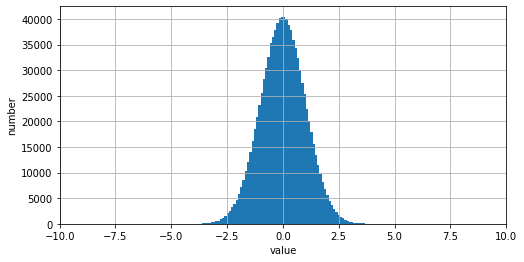

In [73]:
#標準偏差１の正規分布を生成
#pythonではMetsenne Twister法はramdomで標準に用いられているようだが，一応確認．
#100万個の値でグラフを作る．
y = rand.normal(0, 1, 1000000)
plt.figure(figsize=(8, 4))
plt.xlabel("value")
plt.ylabel("number")
plt.grid(True)
plt.hist(y, bins=100)
plt.xlim(-10, 10)
plt.show()

In [76]:
#観測データはそれぞれの時刻の真の値に標準偏差１の正規分布の値を足したものとする．

#真値xtは上で定義
yo = np.zeros((4*365, K))
yo = xt + rand.normal(0, 1, (4*365, K))

xf = np.zeros((4*365, K))
xa = np.zeros((4*365, K))
dxa = np.zeros((4*365, K))
dxf = np.zeros((4*365, K))

xa[0] = yo[0]
xf[0] = yo[0]
delta = 0.00001
R = np.eye(K)
e = np.eye(K)*delta

Pf = np.zeros((4*365, K, K))
Pa = np.zeros((4*365, K, K))
Pa[0] = 5*np.eye(K)

#重み
W = np.zeros((4*365, K, K))

#とりあえずM_0を作ってみる
M = np.zeros((K, K))
for n in range(K):
    Me = (Runge4one(xa[0] + e[n]) - Runge4one(xa[0]))/delta
    M[n] = Me

M = M.T

Pf[1] = np.dot(np.dot(M,  Pa[0]), M.T)
W[1] = np.dot(Pf[1], np.linalg.inv(Pf[1] + R))